# Extended Isolation Forest
## Scalability performance study

In [9]:
import sys
sys.path.append("D:/skola/dip/h2o-3/h2o-py/build") # path to h2o build
sys.path.append("D:/skola/dip/eif") # path to eif_old.py file (git clone https://github.com/sahandha/eif.git)

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import eif_old as iso
import time
import math
import h2o
from h2o.estimators import H2OIsolationForestEstimator
from h2o.estimators import H2OExtendedIsolationForestEstimator
from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_blobs

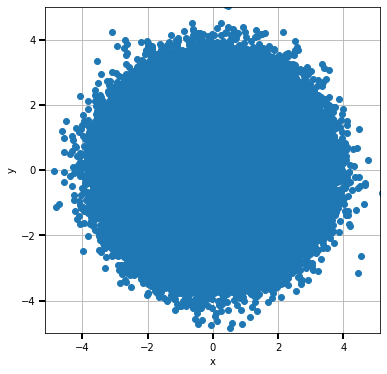

In [29]:
seed = 1234
N = 1_500_000
ntrees = 100
sample_size = 256
max_depth = int(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N, n_features=2)
X = make_blobs(centers=[[0, 0], [0, 0]], cluster_std=1, **blobs_params)[0]

fig=plt.figure(figsize=(6,6))
fig.add_subplot(111)
plt.plot(X[:,0],X[:,1],'o')
plt.grid("off")
plt.axis("equal")
plt.xlim([-5,5])
plt.ylim([-5,5])
plt.xlabel("x")
plt.ylabel("y")
plt.tick_params(direction='out', length=6, width=2)
plt.show()

In [30]:
def test_predict():
    start = time.time()
    EIF_h2o.predict(hf_test)
    end = time.time()
    eif_time = end - start
    print(f"EIF Time: {eif_time}s")
    start = time.time()
    IF_h2o.predict(hf_test)
    end = time.time()
    if_time = end - start
    print(f"IF Time: {if_time}s")    
    return eif_time, if_time


12 - EIF = 5.905624985694885, IF = 6.632323861122131
8 - EIF = 6.544941854476929, IF = 6.5325685977935795
4 - EIF = 9.26952600479126, IF = 9.261695981025696
2 - EIF = 16.783036136627196, IF = 16.78134787082672
1 - EIF = 29.11130585670471, IF = 27.450838899612428
EIF
{12: 5.905624985694885, 8: 6.544941854476929, 4: 9.26952600479126, 2: 16.783036136627196, 1: 29.11130585670471}
IF
{12: 6.632323861122131, 8: 6.5325685977935795, 4: 9.261695981025696, 2: 16.78134787082672, 1: 27.450838899612428}
12
5.905624985694885
8
6.544941854476929
4
9.26952600479126
2
16.783036136627196
1
29.11130585670471
12
6.632323861122131
8
6.5325685977935795
4
9.261695981025696
2
16.78134787082672
1
27.450838899612428


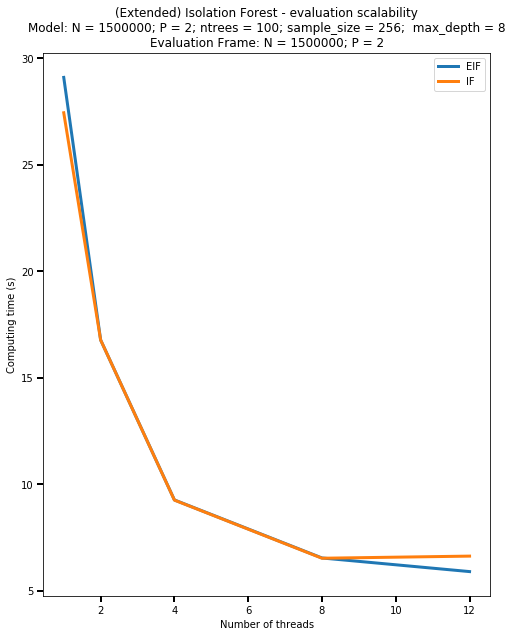

In [41]:
mtries = 10
threds = [12, 8, 4 , 2, 1]

all_times = []
all_times_num_eif = []
all_times_num_if = []
for nthreads in threds:
    times_eif = []
    times_if = []
    h2o.init(nthreads=nthreads)
    blobs_paramss = dict(random_state=seed, n_samples=500_000, n_features=2)
    X_train = make_blobs(centers=[[0, 0], [0, 0]], cluster_std=1, **blobs_paramss)[0]        
    hf_train = h2o.H2OFrame(X_train,column_names = ["x", "y"])    
    hf_test = h2o.H2OFrame(X,column_names = ["x", "y"])
    EIF_h2o = H2OExtendedIsolationForestEstimator(model_id = "extended_isolation_forest.hex",
                                         ntrees = ntrees, seed = seed, sample_size = sample_size, extension_level = 1)
    EIF_h2o.train(training_frame = hf_train)
    IF_h2o = H2OIsolationForestEstimator(model_id = "isolation_forest.hex",
                                     ntrees = ntrees, seed = seed, sample_size = sample_size, max_depth = max_depth)
    IF_h2o.train(training_frame = hf_train)
    for i in range(mtries):
        eif_time, if_time = test_predict()
        times_eif.append(eif_time)
        times_if.append(if_time)
    h2o.cluster().shutdown()
    print(f"EIF {np.mean(times_eif)}s")
    print(f"IF {np.mean(times_if)}s")
    all_times_num_eif.append(times_eif)
    all_times_num_if.append(times_if)
    all_times.append(f"thread {nthreads} - EIF {np.mean(times_eif)}s and IF {np.mean(times_if)}s")
    
sample_256_max_depth_log_eif = dict()
sample_256_max_depth_log_if = dict()
for i, nthreads in enumerate(threds):
    print(f"{nthreads} - EIF = {np.mean(all_times_num_eif[i])}, IF = {np.mean(all_times_num_if[i])}")
    sample_256_max_depth_log_eif[nthreads] = np.mean(all_times_num_eif[i])
    sample_256_max_depth_log_if[nthreads] = np.mean(all_times_num_if[i])

print("EIF")
print(sample_256_max_depth_log_eif)
print("IF")
print(sample_256_max_depth_log_if)

data = {"x":[], "y": [], "label":[]}
for label, coord in sample_256_max_depth_log_eif.items():
    print(label)
    print(coord)
    data["x"].append(label)
    data["y"].append(coord)

data_if = {"x":[], "y": [], "label":[]}
for label, coord in sample_256_max_depth_log_if.items():
    print(label)
    print(coord)
    data_if["x"].append(label)
    data_if["y"].append(coord)    

fig=plt.figure(figsize=(8,10))
fig.add_subplot(111)
plt.plot(data['x'], data['y'], '-', label="EIF", linewidth=3)
plt.plot(data_if['x'], data_if['y'], '-', label="IF", linewidth=3)
# plt.grid("off")
plt.xlabel("Number of threads")
plt.ylabel("Computing time (s)")
plt.legend()
plt.tick_params(direction='out', length=6, width=2) 
plt.title(f"(Extended) Isolation Forest - evaluation scalability\nModel: N = 1500000; P = 2; ntrees = {ntrees}; sample_size = {sample_size};  max_depth = {max_depth}\nEvaluation Frame: N = {N}; P = 2")
plt.savefig(f"h2o-scale-perf_{sample_size}_{N}_{coord}3.eps", bbox_inches='tight', pad_inches=.05)
plt.savefig(f"h2o-scale-perf_{sample_size}_{N}_{coord}3.pdf", bbox_inches='tight', pad_inches=.05)
plt.show()
    


In [44]:
print(all_times_num_if)
print(all_times_num_eif)
print(all_times)

[[19.672342777252197, 20.53502607345581, 19.87462878227234, 19.908703565597534, 18.980705738067627, 19.75950336456299, 18.642748594284058, 18.202144861221313, 20.069458961486816, 18.68135690689087], [19.81078314781189, 20.57333731651306, 21.250260591506958, 21.326552867889404, 22.17860746383667, 22.286158561706543, 21.461563110351562, 22.279206037521362, 21.172695636749268, 20.275078058242798], [26.00801968574524, 26.411422729492188, 26.98170757293701, 25.64406394958496, 26.061084032058716, 25.734219789505005, 26.46064519882202, 25.529783010482788, 26.272348165512085, 25.714040517807007], [38.77704977989197, 38.94839119911194, 40.23340654373169, 40.30915427207947, 40.37308359146118, 41.406450271606445, 40.408451080322266, 40.25383162498474, 40.48889422416687, 38.59671187400818], [70.22407579421997, 72.26861953735352, 69.66379356384277, 70.69624662399292, 70.27181053161621, 69.26559853553772, 70.22999024391174, 74.55966877937317, 70.23043942451477, 66.74626278877258]]
[[137.523073434829

In [71]:
h2o.init(nthreads=12)
hf = h2o.H2OFrame(X,column_names = ["x", "y"])

start = time.time()
IF_h2o = H2OIsolationForestEstimator(model_id = "isolation_forest.hex",
                                 ntrees = ntrees, seed = seed, sample_size = sample_size, max_depth = max_depth)
IF_h2o.train(training_frame = hf)
end = time.time()
if_time = end - start
print(f"IF Time: {if_time}s")
h2o.cluster().shutdown()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3n_ig70w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3n_ig70w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3n_ig70w\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Prague
H2O data parsing timezone:,UTC
H2O cluster version:,3.27.0.99999
H2O cluster version age:,2 days
H2O cluster name:,H2O_from_python_potte_16feyn
H2O cluster total nodes:,1
H2O cluster free memory:,21.27 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
isolationforest Model Build progress: |███████████████████████████████████| 100%
IF Time: 49.78067636489868s
H2O session _sid_a964 closed.


In [40]:
all_times_num_if[0][6] = 6.343793630599976

12
144.42591614723204
8
134.0580631494521
4
72.80119981765748
2
47.28469135761261
1
48.60738940238953
12
19.432661962509155
8
21.261424279212953
4
26.081733465194702
2
39.97954244613648
1
70.41565058231353


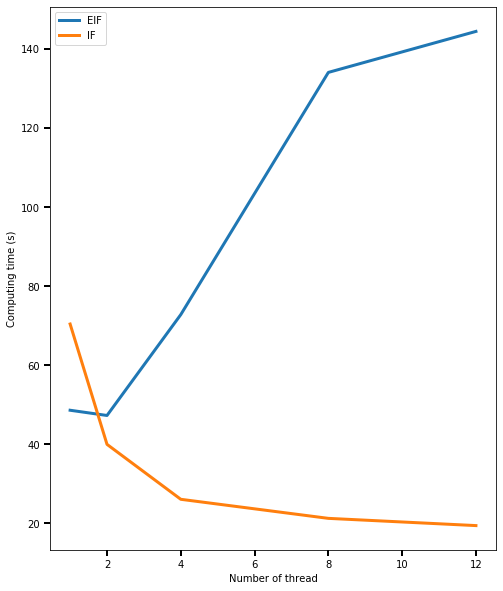

In [99]:
data = {"x":[], "y": [], "label":[]}
for label, coord in sample_30000_max_depth_8_eif.items():
    print(label)
    print(coord)
    data["x"].append(label)
    data["y"].append(coord)
    
data_if = {"x":[], "y": [], "label":[]}
for label, coord in sample_30000_max_depth_8_if.items():
    print(label)
    print(coord)
    data_if["x"].append(label)
    data_if["y"].append(coord)    
    
fig=plt.figure(figsize=(8,10))
fig.add_subplot(111)
plt.plot(data['x'], data['y'], '-', label="EIF", linewidth=3)
plt.plot(data_if['x'], data_if['y'], '-', label="IF", linewidth=3)
# plt.grid("off")
plt.xlabel("Number of thread")
plt.ylabel("Computing time (s)")
plt.legend()
plt.tick_params(direction='out', length=6, width=2) 
plt.show()

In [ ]:
data = {"x":[], "y": [], "label":[]}
for label, coord in sample_256_max_depth_8_eif.items():
    print(label)
    print(coord)
    data["x"].append(label)
    data["y"].append(coord)
    
data_if = {"x":[], "y": [], "label":[]}
for label, coord in sample_256_max_depth_8_if.items():
    print(label)
    print(coord)
    data_if["x"].append(label)
    data_if["y"].append(coord)    
    
fig=plt.figure(figsize=(8,10))
fig.add_subplot(111)
plt.plot(data['x'], data['y'], '-', label="EIF", linewidth=3)
plt.plot(data_if['x'], data_if['y'], '-', label="IF", linewidth=3)
# plt.grid("off")
plt.xlabel("Number of thread")
plt.ylabel("Computing time (s)")
plt.legend()
plt.tick_params(direction='out', length=6, width=2) 
plt.show()

### Compute anomaly score
#### Note:
Negative number of H2O mean length will be used and positive value of sklearn anomaly score

In [ ]:
# Anomaly score for heatmap data

# H2O IF
h2o_anomaly_score = IF_h2o.predict(hf_heatmap).cbind(hf_heatmap)
h2o_anomaly_score_df = h2o_anomaly_score.as_data_frame(use_pandas=True, header=True)
heatmap_h2o_if = np.array(h2o_anomaly_score_df["predict"]).reshape(xx.shape)
heatmap_h2o_mean_length_if = -1*np.array(h2o_anomaly_score_df["mean_length"]).reshape(xx.shape)

# H2O EIF -> Ex0
h2o_anomaly_score_eif_if = EIF_h2o_if.predict(hf_heatmap).cbind(hf_heatmap)
h2o_anomaly_score_df_eif_if = h2o_anomaly_score_eif_if.as_data_frame(use_pandas=True, header=True)
heatmap_h2o_eif_if = np.array(h2o_anomaly_score_df_eif_if["anomaly_score"]).reshape(xx.shape)
heatmap_h2o_mean_length_eif_if = -1*np.array(h2o_anomaly_score_df_eif_if["mean_length"]).reshape(xx.shape)

# H2O EIF
h2o_anomaly_score_eif = EIF_h2o.predict(hf_heatmap).cbind(hf_heatmap)
h2o_anomaly_score_df_eif = h2o_anomaly_score_eif.as_data_frame(use_pandas=True, header=True)
heatmap_h2o_eif = np.array(h2o_anomaly_score_df_eif["anomaly_score"]).reshape(xx.shape)
heatmap_h2o_mean_length_eif = -1*np.array(h2o_anomaly_score_df_eif["mean_length"]).reshape(xx.shape)

# Sklearn
sklearn_anomaly_score = abs(IF_sklearn.score_samples(df_heatmap)) # Sklearn gives negative metrict of the same as 
                                                                 # it is in paper
heatmap_sklearn = sklearn_anomaly_score.reshape(xx.shape)
print("Sklearn anomaly scoring done")

# Paper IF
paper_anomaly_score_if = IF_paper.compute_paths(X_heatmap)
heatmap_paper_if = paper_anomaly_score_if.reshape(xx.shape)
print("Paper IF anomaly scoring done")

# Paper EIF
paper_anomaly_score_eif = EIF_paper.compute_paths(X_heatmap)
heatmap_paper_eif = paper_anomaly_score_eif.reshape(xx.shape)
print("Paper EIF anomaly scoring done")

### Plot anomaly score

* Mean length = Mean path lengt through the forest to separate an observation. 

H2O plot has a white spots because all colorbars are between [0,1] but h2o has inconsistent anomaly score with other implementations. It can be higher than 1 and lower than 0.

Sklear and paper implementation of IF/EIF use anomaly score normalization from the paper. [1] [2]

In [ ]:
f = plt.figure(figsize=(29,24))

def plot_heatmap(heatmap_data, subplot, title): 

    ax1 = f.add_subplot(subplot)
    levels = np.linspace(0,1,25, endpoint=True)
    v = np.linspace(0, 1, 12, endpoint=True)
    v = np.around(v, decimals=1)
    CS = ax1.contourf(xx, yy, heatmap_data, levels, cmap=plt.cm.YlOrRd)
    cbar = plt.colorbar(CS, ticks=v)
    cbar.ax.set_ylabel('Anomaly score', fontsize = 25)
    cbar.ax.tick_params(labelsize=15)
    ax1.set_xlabel("x", fontsize = 25)
    ax1.set_ylabel("y", fontsize = 25)
    plt.tick_params(labelsize=30)
    plt.scatter(x,y,s=15,c='None',edgecolor='k')
    plt.axis("equal")
    plt.title(title,  fontsize=32)
    
plot_heatmap(heatmap_h2o_if, 221, "H2O IF - normalized mean length")
plot_heatmap(heatmap_sklearn, 222, "Sklearn Isolation Forest")
plot_heatmap(heatmap_h2o_eif_if, 223, "H2O - Extended Isolation Forest Ex=0")
plot_heatmap(heatmap_paper_if, 224, "Paper Isolation Forest")

plt.show()

In [ ]:
f = plt.figure(figsize=(29,24))
    
plot_heatmap(heatmap_h2o_if, 221, "H2O IF - normalized mean length")
plot_heatmap(heatmap_h2o_eif_if, 222, "H2O - Extended Isolation Forest Ex0")
plot_heatmap(heatmap_h2o_eif, 223, "H2O - Extended Isolation Forest")
plot_heatmap(heatmap_paper_eif, 224, "Paper Isolation Forest")

plt.show()

### Plot also H2O mean length values 

In [ ]:
f = plt.figure(figsize=(47,81))

def plot_heatmap(heatmap_data, subplot, title): 

    ax1 = f.add_subplot(subplot)
    levels = np.linspace(0,1,25, endpoint=True)
    v = np.linspace(0, 1, 12, endpoint=True)
    v = np.around(v, decimals=1)
    CS = ax1.contourf(xx, yy, heatmap_data, levels, cmap=plt.cm.YlOrRd)
    cbar = plt.colorbar(CS, ticks=v)
    cbar.ax.set_ylabel('Anomaly score', fontsize = 27)
    cbar.ax.tick_params(labelsize=24)
    ax1.set_xlabel("x", fontsize = 24)
    ax1.set_ylabel("y", fontsize = 24)
    plt.tick_params(labelsize=30)
    plt.scatter(x,y,s=1,c='None',edgecolor='k')
    plt.axis("equal")
    plt.title(title,  fontsize=35)
    
# H2O
plot_heatmap(heatmap_h2o_if, 421, "H2O - normalized mean length")

# H2O - Mean length
ax1 = f.add_subplot(422)
levels = np.linspace(np.min(heatmap_h2o_mean_length_if), np.max(heatmap_h2o_mean_length_if),50, endpoint=True)
v = np.linspace(np.min(heatmap_h2o_mean_length_if), np.max(heatmap_h2o_mean_length_if),12, endpoint=True)
v = np.around(v, decimals = 2)
CS = ax1.contourf(xx, yy, heatmap_h2o_mean_length_if, levels, cmap=plt.cm.YlOrRd)
cbar = plt.colorbar(CS, ticks = v)
cbar.ax.set_ylabel('Anomaly score', fontsize = 27)
cbar.ax.tick_params(labelsize=24)
ax1.set_xlabel("x", fontsize = 24)
ax1.set_ylabel("y", fontsize = 24)
plt.tick_params(labelsize=30)
plt.scatter(x,y,s=1,c='None',edgecolor='k')
plt.axis("equal")
plt.title("H2O - mean length",  fontsize=35)

plot_heatmap(heatmap_h2o_eif_if, 423, "H2O - Extended Isolation Forest - Ex0")
plot_heatmap(heatmap_sklearn, 424, "Sklearn Isolation Forest")
plot_heatmap(heatmap_paper_if, 425, "Paper Isolation Forest")
plot_heatmap(heatmap_h2o_eif, 427, "H2O - Extended Isolation Forest")
plot_heatmap(heatmap_paper_eif, 428, "Paper Extended Isolation Foreset")

plt.show()

In [ ]:
hf44 = h2o.H2OFrame([[4,4],[4,-4]], column_names = ["x", "y"]) 

predictions44 = IF_h2o.predict(hf44).cbind(hf44)
dfp44 = predictions44.as_data_frame(use_pandas=True, header=True)
dfp44

In [ ]:
# Paper EIF
paper_anomaly_score_eif = EIF_paper.compute_paths([[0,0]])
print(paper_anomaly_score_eif)
paper_anomaly_score_if = IF_paper.compute_paths([[0,0]])
print(paper_anomaly_score_if)
# print("Paper EIF anomaly scoring done")

# Acronyms

* IF = Isolation Forest
* EIF = Extended Isolation Forest
* Ex0 = extension_level parameter = 0. It means that Extended Isolation Forest behave like Isolation Forest.
* Ex1 = extension_level parameter = 1

# Bibliography

* [1] sahandha /eif: https://github.com/sahandha/eif
* [2] S. Hariri, M. Carrasco Kind and R. J. Brunner, "Extended Isolation Forest," in IEEE Transactions on Knowledge and Data Engineering, doi: 10.1109/TKDE.2019.2947676. Available from:http://dx.doi.org/10.1109/TKDE.2019.2947676